In [17]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import models



In [18]:
# Parameter
num_classes = 4  # Jumlah kelas dalam dataset
batch_size = 32   # Ukuran batch
learning_rate = 0.001  # Learning rate awal


# Periksa GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# **1. Preprocessing dan Dataloader**
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Path dataset
data_dir = "C:\\Users\\Ilmu Komputer\\OneDrive\\Desktop\\Sempro\\hasil_preprocessing"


if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Path dataset tidak ditemukan: {data_dir}")

# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir)

# Pembagian dataset: Train, Validation, Test
num_samples = len(full_dataset)
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = eval_transforms
test_dataset.dataset.transform = eval_transforms

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)






Using device: cuda


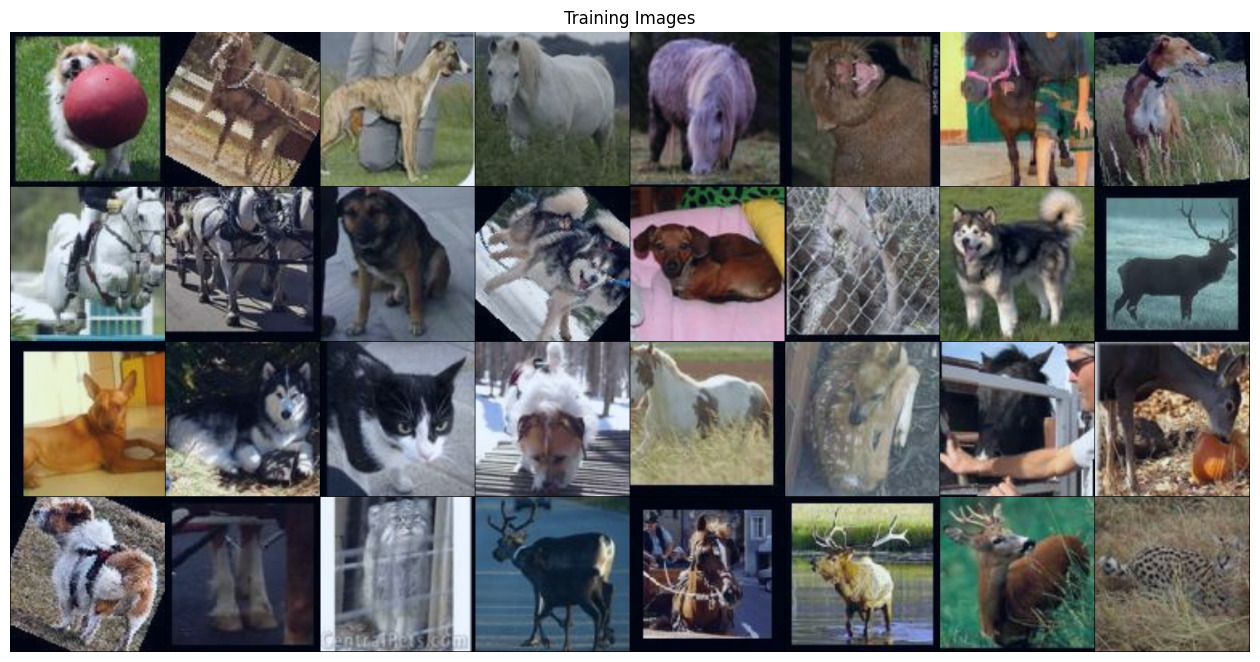

In [19]:

# Ambil satu batch dari train_loader
real_batch = next(iter(train_loader))

# Tampilkan hingga 128 gambar dalam grid besar
plt.figure(figsize=(16, 16))  # Ukuran figure diperbesar
plt.axis("off")
plt.title("Training Images")

# Susun dan tampilkan gambar dalam grid
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:128], padding=1, normalize=True).cpu(),
        (1, 2, 0)
    )
)
plt.show()


In [20]:

# **2. Model dan Transfer Learning**






# **EfficientNet-B0**
class CustomEfficientNetB0(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB0, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=False)
        self.in_features = self.efficientnet.classifier[1].in_features  # Ambil in_features sebelum diubah
        self.efficientnet.classifier[1] = nn.Identity()  # Ubah layer kedua menjadi Identity
        self.fc = nn.Linear(self.in_features, num_classes)  # Buat classifier baru

    def forward(self, x):
        features = self.efficientnet(x)  # Pass input melalui EfficientNet
        return self.fc(features)  # Pass extracted features melalui custom classifier



efficientnet = CustomEfficientNetB0(num_classes=num_classes).to(device)




# **MobileNetV2**
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV2, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=False)
        self.in_features = self.mobilenet.classifier[1].in_features  # Ambil in_features sebelum diubah
        self.mobilenet.classifier[1] = nn.Identity()  # Remove original classifier
        self.fc = nn.Linear(self.in_features, num_classes)
        
    def forward(self, x):
        features = self.mobilenet(x)  # Pass input through feature extractor
        return self.fc(features)  # Pass extracted features through custom classifier

mobilenet = CustomMobileNetV2(num_classes=num_classes).to(device)











c:\conda\miniconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\conda\miniconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:



def train_model_dynamic(model, criterion, optimizer, train_loader, val_loader, patience=5, model_name="model"):

    print("Model's classifier:", model.fc if hasattr(model, 'fc') else "No fc found")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []   
    still_training = True
    epoch = 0
    
    
    
    best_val_loss = float('inf')
    no_improve_count = 0
    frozen = True
    
    for param in model.parameters():
        param.requires_grad = False
    for param in model.module.fc.parameters() if hasattr(model, 'module') else model.fc.parameters():
        param.requires_grad = True

    while still_training:
        epoch += 1
        print(f"Epoch {epoch} {'[Frozen]' if frozen else '[Unfrozen]'}")

        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)  

        # Validation
        val_loss, correct, total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)

        print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


        # Early stopping dan unfreeze
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_count = 0
            torch.save(model.state_dict(), model_name)  # Simpan model terbaik
        else:
            no_improve_count += 1

        # Unfreeze jika tidak ada peningkatan setelah beberapa iterasi
        if no_improve_count >= patience and frozen:
            print("Unfreezing model backbone...")
            for param in model.parameters():
                param.requires_grad = True
            frozen = False
            no_improve_count = 0
            optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # Update optimizer untuk melatih seluruh model
        
        # Stop jika tidak ada peningkatan signifikan
        if no_improve_count >= patience and not frozen:
            print("Early stopping triggered.")
            break

    return model, train_losses, val_losses, train_accs, val_accs








def test_model(model, test_loader, criterion, model_name):
    model.load_state_dict(torch.load(model_name))  # Load model terbaik sebelum pengujian
    model.eval()
    correct, total, test_loss = 0, 0, 0
    all_preds, all_labels = [], []  # Inisialisasi list sebelum loop
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  


    test_acc = correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Acc: {test_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))



    class_labels = ['cat', 'deer', 'dog', 'horse']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)




    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    return test_loss / len(test_loader), test_acc

    





Training EfficientNet-B0...
Model's classifier: Linear(in_features=1280, out_features=4, bias=True)
Epoch 1 [Frozen]
Train Loss: 1.3964, Val Loss: 1.3937, Train Acc: 0.2964, Val Acc: 0.3048
Epoch 2 [Frozen]
Train Loss: 1.3862, Val Loss: 1.3996, Train Acc: 0.3071, Val Acc: 0.3072
Epoch 3 [Frozen]
Train Loss: 1.3913, Val Loss: 1.3886, Train Acc: 0.3092, Val Acc: 0.3144
Epoch 4 [Frozen]
Train Loss: 1.3864, Val Loss: 1.3735, Train Acc: 0.3068, Val Acc: 0.3093
Epoch 5 [Frozen]
Train Loss: 1.3893, Val Loss: 1.4110, Train Acc: 0.3120, Val Acc: 0.3216
Epoch 6 [Frozen]
Train Loss: 1.3836, Val Loss: 1.3735, Train Acc: 0.3140, Val Acc: 0.3277
Epoch 7 [Frozen]
Train Loss: 1.3933, Val Loss: 1.3616, Train Acc: 0.3147, Val Acc: 0.3210
Epoch 8 [Frozen]
Train Loss: 1.3865, Val Loss: 1.4141, Train Acc: 0.3128, Val Acc: 0.3122
Epoch 9 [Frozen]
Train Loss: 1.3906, Val Loss: 1.3803, Train Acc: 0.3106, Val Acc: 0.3307
Epoch 10 [Frozen]
Train Loss: 1.3852, Val Loss: 1.4067, Train Acc: 0.3241, Val Acc: 0.321

C:\Users\Ilmu Komputer\AppData\Local\Temp\ipykernel_9240\2160589854.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))  # Loa

Test Loss: 0.5590, Test Acc: 0.8117


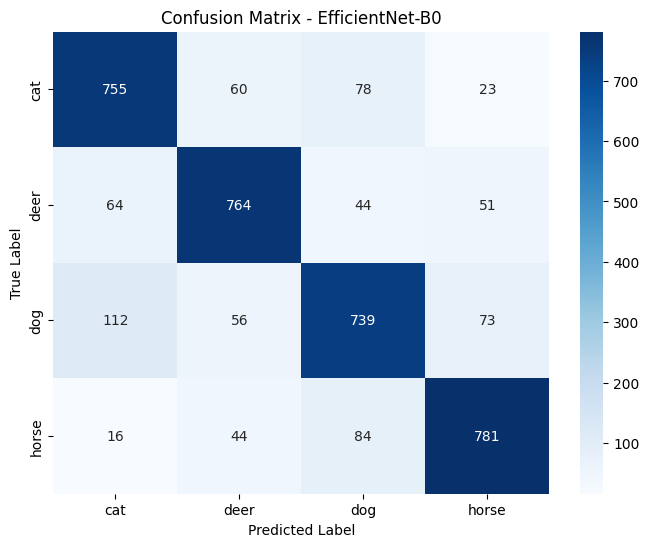


Training MobileNetV2...
Model's classifier: Linear(in_features=1280, out_features=4, bias=True)
Epoch 1 [Frozen]
Train Loss: 1.3893, Val Loss: 1.3700, Train Acc: 0.3013, Val Acc: 0.2791
Epoch 2 [Frozen]
Train Loss: 1.3862, Val Loss: 1.4031, Train Acc: 0.3051, Val Acc: 0.3077
Epoch 3 [Frozen]
Train Loss: 1.3758, Val Loss: 1.3709, Train Acc: 0.3143, Val Acc: 0.2983
Epoch 4 [Frozen]
Train Loss: 1.3790, Val Loss: 1.3620, Train Acc: 0.3094, Val Acc: 0.3141
Epoch 5 [Frozen]
Train Loss: 1.3788, Val Loss: 1.3554, Train Acc: 0.3151, Val Acc: 0.3304
Epoch 6 [Frozen]
Train Loss: 1.3757, Val Loss: 1.3760, Train Acc: 0.3126, Val Acc: 0.3352
Epoch 7 [Frozen]
Train Loss: 1.3813, Val Loss: 1.3564, Train Acc: 0.3132, Val Acc: 0.3240
Epoch 8 [Frozen]
Train Loss: 1.3790, Val Loss: 1.3555, Train Acc: 0.3147, Val Acc: 0.3379
Epoch 9 [Frozen]
Train Loss: 1.3798, Val Loss: 1.3513, Train Acc: 0.3127, Val Acc: 0.3189
Epoch 10 [Frozen]
Train Loss: 1.3812, Val Loss: 1.3707, Train Acc: 0.3111, Val Acc: 0.3202
Ep

C:\Users\Ilmu Komputer\AppData\Local\Temp\ipykernel_9240\2160589854.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))  # Loa

Test Loss: 0.5365, Test Acc: 0.8053


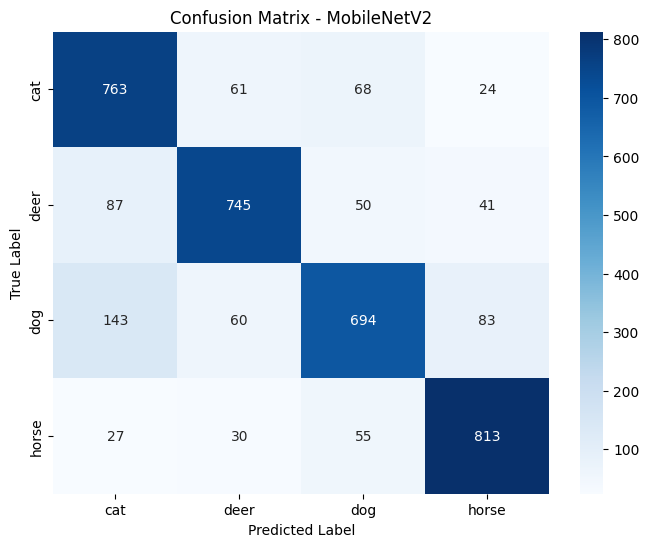

In [22]:


# **4. Pelatihan dan Evaluasi**
results = {}

for model_name, model in zip(["EfficientNet-B0", "MobileNetV2"],
                             [efficientnet, mobilenet]):
    print(f"\nTraining {model_name}...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    

        
    model, train_losses, val_losses, train_accs, val_accs = train_model_dynamic(
    model, criterion, optimizer, train_loader, val_loader, patience=5, model_name=model_name)

    
    test_loss, test_acc = test_model(model, test_loader, criterion, model_name=model_name)
    results[model_name] = {
        "train_accs": train_accs,
        "val_accs": val_accs,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "train_losses": train_losses,
        "val_losses": val_losses
    }





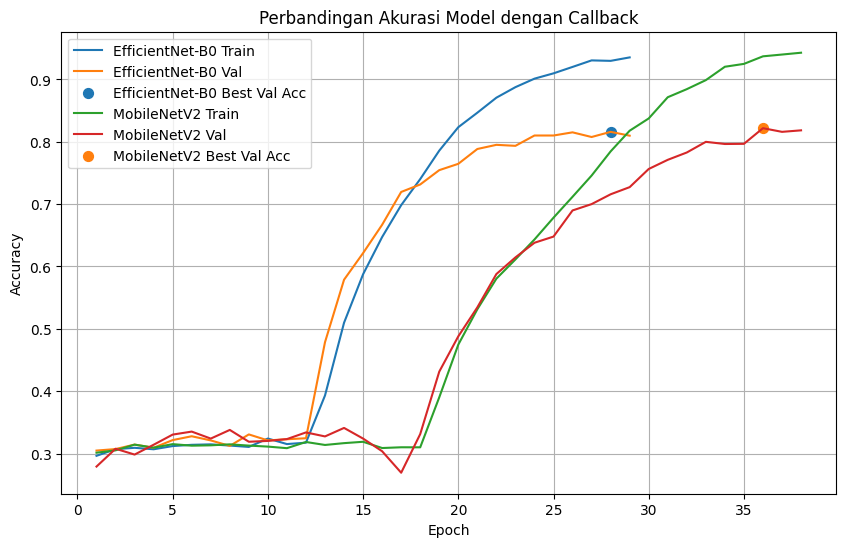

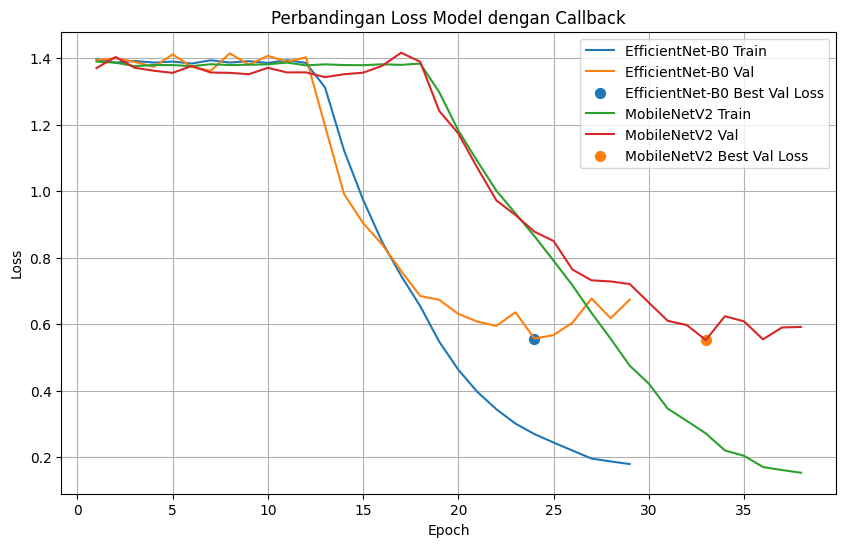

In [23]:

# Plot Grafik Akurasi
plt.figure(figsize=(10, 6))
for model_name in results:
    train_accs = results[model_name]["train_accs"]
    val_accs = results[model_name]["val_accs"]
    epochs = range(1, len(train_accs) + 1)

    # Plot garis akurasi
    plt.plot(epochs, train_accs, label=f"{model_name} Train")
    plt.plot(epochs, val_accs, label=f"{model_name} Val")

    # Temukan akurasi tertinggi pada validasi
    best_val_acc_epoch = val_accs.index(max(val_accs)) + 1
    best_val_acc = max(val_accs)
    
    # Tandai akurasi tertinggi
    plt.scatter(best_val_acc_epoch, best_val_acc, label=f"{model_name} Best Val Acc", s=50)

plt.title("Perbandingan Akurasi Model dengan Callback")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot Grafik Loss
plt.figure(figsize=(10, 6))
for model_name in results:
    train_losses = results[model_name]["train_losses"]
    val_losses = results[model_name]["val_losses"]
    epochs = range(1, len(train_losses) + 1)

    # Plot garis loss
    plt.plot(epochs, train_losses, label=f"{model_name} Train")
    plt.plot(epochs, val_losses, label=f"{model_name} Val")

    # Temukan loss terendah pada validasi
    best_val_loss_epoch = val_losses.index(min(val_losses)) + 1
    best_val_loss = min(val_losses)
    
    # Tandai loss terendah
    plt.scatter(best_val_loss_epoch, best_val_loss, label=f"{model_name} Best Val Loss", s=50)

plt.title("Perbandingan Loss Model dengan Callback")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

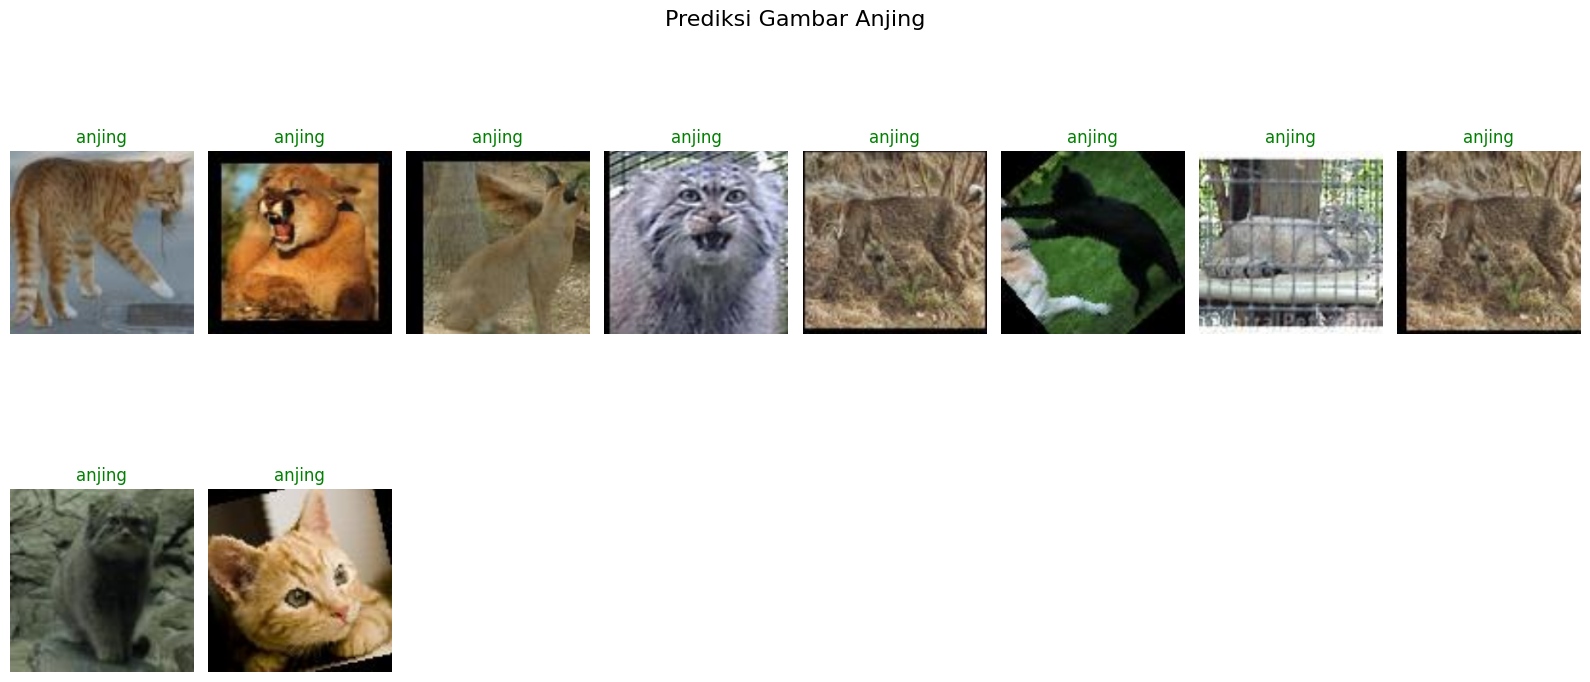

In [24]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Ambil satu batch dari test_loader
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# Lakukan prediksi
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Tentukan nama kelas
class_names = full_dataset.classes  # Misalnya ['anjing', 'kucing', 'sapi', 'kuda']

# Ambil hanya gambar-gambar dengan label aslinya "anjing"
anjing_class_index = class_names.index("cat")
mask = labels == anjing_class_index
anjing_images = images[mask]
anjing_labels = labels[mask]
anjing_preds = preds[mask]

# Tampilkan maksimal 16 gambar anjing
n = min(16, anjing_images.size(0))
plt.figure(figsize=(16, 8))
for i in range(n):
    img = anjing_images[i].cpu()
    true_label = anjing_labels[i].item()
    pred_label = anjing_preds[i].item()

    # Unnormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.clamp(0, 1)

    plt.subplot(2, 8, i + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.axis("off")
    
    # Caption
    if pred_label == true_label:
        plt.title("anjing", color="green", fontsize=12)
    else:
        plt.title(f"Prediksi: {class_names[pred_label]}", color="red", fontsize=12)

plt.suptitle("Prediksi Gambar Anjing", fontsize=16)
plt.tight_layout()
plt.show()
